# Regressão II - parte 2

Regressão múltipla

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [494]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import mean_squared_error

In [286]:
df = pd.read_csv('previsao_de_renda.csv')
print(df.shape)
df.head(2)

(15000, 15)


,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15


In [287]:
# Removendo variáveis não relevantes
df = df.drop(['Unnamed: 0', 'data_ref', 'id_cliente'], axis=1)

In [288]:
print(df.shape)
df.head(2)

(15000, 12)


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15


In [289]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sexo                   15000 non-null  object 
 1   posse_de_veiculo       15000 non-null  bool   
 2   posse_de_imovel        15000 non-null  bool   
 3   qtd_filhos             15000 non-null  int64  
 4   tipo_renda             15000 non-null  object 
 5   educacao               15000 non-null  object 
 6   estado_civil           15000 non-null  object 
 7   tipo_residencia        15000 non-null  object 
 8   idade                  15000 non-null  int64  
 9   tempo_emprego          12427 non-null  float64
 10  qt_pessoas_residencia  15000 non-null  float64
 11  renda                  15000 non-null  float64
dtypes: bool(2), float64(3), int64(2), object(5)
memory usage: 1.2+ MB


In [290]:
# Avaliando dados faltantes
df.isna().sum()

sexo                        0
posse_de_veiculo            0
posse_de_imovel             0
qtd_filhos                  0
tipo_renda                  0
educacao                    0
estado_civil                0
tipo_residencia             0
idade                       0
tempo_emprego            2573
qt_pessoas_residencia       0
renda                       0
dtype: int64

In [291]:
# Removendo dados faltantes
df.dropna(inplace=True)
df.isna().sum()

sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

In [292]:
# Verificando as variáveis categóricas
df.select_dtypes('object').describe().T

,count,unique,top,freq
sexo,12427,2,F,7901
tipo_renda,12427,5,Assalariado,7633
educacao,12427,5,Secundário,7045
estado_civil,12427,5,Casado,8897
tipo_residencia,12427,6,Casa,11071


In [293]:
# Gerando variáveis dummy
df_treated = pd.get_dummies(df, prefix_sep='_')
df_treated.head(2)

,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,sexo_F,sexo_M,tipo_renda_Assalariado,...,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,False,True,0,26,6.602740,1.0,8060.34,True,False,False,...,False,True,False,False,False,True,False,False,False,False
1,True,True,0,28,7.183562,2.0,1852.15,False,True,True,...,False,False,False,False,False,True,False,False,False,False


In [294]:
# Removendo os espaços desnecessário no nome das colunas

col_names = [_.replace(' ', '_') for _ in df_treated.columns]
print(len(col_names))
print(col_names,end='')

30
['posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'sexo_F', 'sexo_M', 'tipo_renda_Assalariado', 'tipo_renda_Bolsista', 'tipo_renda_Empresário', 'tipo_renda_Pensionista', 'tipo_renda_Servidor_público', 'educacao_Primário', 'educacao_Pós_graduação', 'educacao_Secundário', 'educacao_Superior_completo', 'educacao_Superior_incompleto', 'estado_civil_Casado', 'estado_civil_Separado', 'estado_civil_Solteiro', 'estado_civil_União', 'estado_civil_Viúvo', 'tipo_residencia_Aluguel', 'tipo_residencia_Casa', 'tipo_residencia_Com_os_pais', 'tipo_residencia_Comunitário', 'tipo_residencia_Estúdio', 'tipo_residencia_Governamental']

In [295]:
df_treated.columns

Index(['posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'idade',
       'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'sexo_F', 'sexo_M',
       'tipo_renda_Assalariado', 'tipo_renda_Bolsista',
       'tipo_renda_Empresário', 'tipo_renda_Pensionista',
       'tipo_renda_Servidor público', 'educacao_Primário',
       'educacao_Pós graduação', 'educacao_Secundário',
       'educacao_Superior completo', 'educacao_Superior incompleto',
       'estado_civil_Casado', 'estado_civil_Separado', 'estado_civil_Solteiro',
       'estado_civil_União', 'estado_civil_Viúvo', 'tipo_residencia_Aluguel',
       'tipo_residencia_Casa', 'tipo_residencia_Com os pais',
       'tipo_residencia_Comunitário', 'tipo_residencia_Estúdio',
       'tipo_residencia_Governamental'],
      dtype='object')

In [296]:
# Remomeando as colunas

df_treated.columns = col_names
print(df_treated.columns)
df_treated = df_treated.astype(float) # Deixando os dados como float
print(df_treated.shape)
df_treated.head()

Index(['posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'idade',
       'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'sexo_F', 'sexo_M',
       'tipo_renda_Assalariado', 'tipo_renda_Bolsista',
       'tipo_renda_Empresário', 'tipo_renda_Pensionista',
       'tipo_renda_Servidor_público', 'educacao_Primário',
       'educacao_Pós_graduação', 'educacao_Secundário',
       'educacao_Superior_completo', 'educacao_Superior_incompleto',
       'estado_civil_Casado', 'estado_civil_Separado', 'estado_civil_Solteiro',
       'estado_civil_União', 'estado_civil_Viúvo', 'tipo_residencia_Aluguel',
       'tipo_residencia_Casa', 'tipo_residencia_Com_os_pais',
       'tipo_residencia_Comunitário', 'tipo_residencia_Estúdio',
       'tipo_residencia_Governamental'],
      dtype='object')
(12427, 30)


,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,sexo_F,sexo_M,tipo_renda_Assalariado,...,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com_os_pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,0.0,1.0,0.0,26.0,6.602740,1.0,8060.34,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,28.0,7.183562,2.0,1852.15,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,35.0,0.838356,2.0,2253.89,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,30.0,4.846575,3.0,6600.77,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,33.0,4.293151,1.0,6475.97,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### <span style='color:blue'> 1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).

In [298]:
# Qubrando o banco de dados em variável explicativa e resposta

# Explicativa
X = df_treated.drop('renda', axis=1)
# Resposta
Y = df_treated[['renda']]

X.shape, Y.shape

((12427, 29), (12427, 1))

In [299]:
# Dividindo o banco de dados em treino e teste

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=.75, test_size=.25, random_state=100)

In [300]:
# Avaliando as dimensões dos grupos treino e teste
print('--> Dados de x para treino: {}'.format(x_train.shape))
print('--> Dados de x para teste: {}'.format(x_test.shape))
print('--> Dados de y para treino: {}'.format(y_train.shape))
print('--> Dados de y para teste: {}'.format(y_test.shape))

--> Dados de x para treino: (9320, 29)
--> Dados de x para teste: (3107, 29)
--> Dados de y para treino: (9320, 1)
--> Dados de y para teste: (3107, 1)


##### <span style='color:purple'> Criando os bancos de dados de treino e teste

In [302]:
# Treino
df_train = pd.concat([y_train, x_train], axis=1)
print(df_train.shape)
df_train.head()

(9320, 30)


,renda,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,sexo_F,sexo_M,tipo_renda_Assalariado,...,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com_os_pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
3889,1338.93,1.0,0.0,0.0,50.0,3.441096,2.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14483,20103.27,0.0,0.0,0.0,52.0,2.745205,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
762,839.21,1.0,0.0,0.0,38.0,6.539726,2.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3078,819.95,1.0,1.0,0.0,27.0,7.624658,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10423,3333.73,0.0,0.0,0.0,47.0,4.550685,2.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [303]:
# Teste 
df_test = pd.concat([y_test, x_test], axis=1)
print(df_test.shape)
df_test.head()

(3107, 30)


,renda,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,sexo_F,sexo_M,tipo_renda_Assalariado,...,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com_os_pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
3740,11019.60,0.0,1.0,0.0,47.0,4.553425,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13261,3442.40,0.0,1.0,1.0,33.0,13.432877,3.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14972,3556.27,0.0,1.0,1.0,40.0,2.016438,3.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4190,4323.18,1.0,1.0,1.0,40.0,2.153425,3.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3962,10022.42,1.0,1.0,0.0,44.0,12.435616,2.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [304]:
# Vamos criar uma string concatenando as colunas associadas as 
# variáveis explicativas 
# Uma vez que x.columns no retorna uma lista, podemose fazer:

col_name_list = list(df_treated.columns)
# removendo "renda" da lista (variável resposta)
col_name_list.remove('renda') 
print(col_name_list, end='')

['posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'sexo_F', 'sexo_M', 'tipo_renda_Assalariado', 'tipo_renda_Bolsista', 'tipo_renda_Empresário', 'tipo_renda_Pensionista', 'tipo_renda_Servidor_público', 'educacao_Primário', 'educacao_Pós_graduação', 'educacao_Secundário', 'educacao_Superior_completo', 'educacao_Superior_incompleto', 'estado_civil_Casado', 'estado_civil_Separado', 'estado_civil_Solteiro', 'estado_civil_União', 'estado_civil_Viúvo', 'tipo_residencia_Aluguel', 'tipo_residencia_Casa', 'tipo_residencia_Com_os_pais', 'tipo_residencia_Comunitário', 'tipo_residencia_Estúdio', 'tipo_residencia_Governamental']

In [305]:
# Definindo uma string com as variáveis 

string = " + ".join(col_name_list)
string

'posse_de_veiculo + posse_de_imovel + qtd_filhos + idade + tempo_emprego + qt_pessoas_residencia + sexo_F + sexo_M + tipo_renda_Assalariado + tipo_renda_Bolsista + tipo_renda_Empresário + tipo_renda_Pensionista + tipo_renda_Servidor_público + educacao_Primário + educacao_Pós_graduação + educacao_Secundário + educacao_Superior_completo + educacao_Superior_incompleto + estado_civil_Casado + estado_civil_Separado + estado_civil_Solteiro + estado_civil_União + estado_civil_Viúvo + tipo_residencia_Aluguel + tipo_residencia_Casa + tipo_residencia_Com_os_pais + tipo_residencia_Comunitário + tipo_residencia_Estúdio + tipo_residencia_Governamental'

In [306]:
# Gerando a matriz design e a matriz da variável resposta y
# Considerando o banco de dados completo df_treated

y, x = patsy.dmatrices('renda ~ '+string, data=df_treated)
# x

In [307]:
# Fitting

model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     178.0
Date:                Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:03:08   Log-Likelihood:            -1.2879e+05
No. Observations:               12427   AIC:                         2.576e+05
Df Residuals:                   12402   BIC:                         2.578e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      -988.9316    815.189     -1.213      0.225   -2586.829     608.966
posse_de_veiculo                 48.9098    150.374      0.325      0.745    -245.846     343.666
posse_de_imovel                 366.5747    148.723      2.465      0.014      75.054     658.095
qtd_filhos                    -1126.6107   1147.916     -0.981      0.326   -3376.703    1123.482
idade                            42.0025      8.517      4.931      0.000      25.307      58.698
tempo_emprego                   554.7551     11.044     50.230      0.000     533.107     576.404
qt_pessoas_residencia          1269.8493   1145.868      1.108      0.268    -976.229    3515.928
sexo_F                        -3520.8954    414.765     -8.489      0.000   -4333.900   -2707.891
sexo_M                         2531.9638    415.189      6.098      0.000    1718.128    3345.800
tipo_renda_Assalariado          418.2357    683.418      0.612      0.541    -921.369    1757.841
tipo_renda_Bolsista            -939.4817   2154.005     -0.436      0.663   -5161.666    3282.703
tipo_renda_Empresário          1241.3817    686.196      1.809      0.070    -103.669    2586.432
tipo_renda_Pensionista        -2264.3973   2152.956     -1.052      0.293   -6484.525    1955.730
tipo_renda_Servidor_público     555.3300    700.767      0.792      0.428    -818.282    1928.942
educacao_Primário              -826.5594    699.736     -1.181      0.238   -2198.151     545.033
educacao_Pós_graduação          263.9470   1254.767      0.210      0.833   -2195.592    2723.486
educacao_Secundário            -219.2313    363.328     -0.603      0.546    -931.410     492.947
educacao_Superior_completo      398.9993    363.191      1.099      0.272    -312.911    1110.910
educacao_Superior_incompleto   -606.0872    437.650     -1.385      0.166   -1463.949     251.775
estado_civil_Casado            -709.6344    841.778     -0.843      0.399   -2359.650     940.381
estado_civil_Separado           451.4752    414.872      1.088      0.277    -361.738    1264.689
estado_civil_Solteiro           110.2672    371.161      0.297      0.766    -617.265     837.799
estado_civil_União            -1184.9678    861.435     -1.376      0.169   -2873.514     503.578
estado_civil_Viúvo              343.9282    493.773      0.697      0.486    -623.944    1311.801
tipo_residencia_Aluguel           1.1604    544.052      0.002      0.998   -1065.266    1067.587
tipo_residencia_Casa           -297.1484    278.847     -1.066      0.287    -843.732     249.435
tipo_residencia_Com_os_pais    -387.6386    365.152     -1.062      0.288   -1103.392     328.115
tipo_residencia_Comunitário    -458.6680    846.099     -0.542      0.588   -2117.153    1199.817
tipo_residencia_Estúdio          78.3985    7

### <span style='color:blue'> 2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo? </span>

Assumindo a relação para **Elastic net**

$$L_E = \sum_{i=1}^{N} \left( y_i - \hat{y_i} \right)^2 
    + \alpha \left( L1_{wt} \sum_{k=0}^{M} \left| \beta_k \right|
                    + (1-L1_{wt}) \sum_{k=0}^{M} \left( \beta_k \right)^2
             \right),$$

quando $L1 = 0$ temos apenas a regularização *Ridge* e quando $L1 = 1$, apenas a regularização *Lasso*.

In [311]:
# Aplicando uma regularização ridge
patsy_info = 'renda ~' + string
modelo = smf.ols(patsy_info, df_test)

# Alpha =0
reg_ridge = modelo.fit_regularized(method='elastic_net',
                        refit = True, # Caso uma variável zere o fit e rodado novamente
                        L1_wt = 0.0001, # peso somente no Lasso, olhar equação 
                        alpha = 0.0)
reg_ridge.summary()

C:\Users\theta\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1967: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     44.76
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          3.25e-216
Time:                        16:03:09   Log-Likelihood:                -31733.
No. Observations:                3107   AIC:                         6.353e+04
Df Residuals:                    3077   BIC:                         6.371e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -1720.4915   3004.798     -0.573      0.567   -7612.105    4171.122
posse_de_veiculo               -157.9320    259.531     -0.609      0.543    -666.803     350.939
posse_de_imovel                 564.1797    260.663      2.164      0.031      53.088    1075.272
qtd_filhos                    -1019.5787   4713.324     -0.216      0.829   -1.03e+04    8222.001
idade                            49.7886     14.977      3.324      0.001      20.422      79.155
tempo_emprego                   516.3423     19.344     26.692      0.000     478.413     554.271
qt_pessoas_residencia          1663.0963   4705.613      0.353      0.724   -7563.366    1.09e+04
sexo_F                        -3800.7884   1507.075     -2.522      0.012   -6755.764    -845.813
sexo_M                         2080.2969   1509.827      1.378      0.168    -880.075    5040.669
tipo_renda_Assalariado          635.2126   1461.921      0.435      0.664   -2231.227    3501.652
tipo_renda_Bolsista            -760.6073   2788.236     -0.273      0.785   -6227.599    4706.385
tipo_renda_Empresário          1731.7412   1464.272      1.183      0.237   -1139.309    4602.791
tipo_renda_Pensionista        -4730.9107   5490.637     -0.862      0.389   -1.55e+04    6034.775
tipo_renda_Servidor_público    1404.0728   1484.533      0.946      0.344   -1506.703    4314.848
educacao_Primário               286.5868   1443.514      0.199      0.843   -2543.763    3116.937
educacao_Pós_graduação         -838.5385   2796.856     -0.300      0.764   -6322.433    4645.356
educacao_Secundário            -516.8439    912.113     -0.567      0.571   -2305.256    1271.568
educacao_Superior_completo      697.0498    911.624      0.765      0.445   -1090.404    2484.504
educacao_Superior_incompleto  -1348.7456   1011.683     -1.333      0.183   -3332.387     634.896
estado_civil_Casado           -1019.2651   3408.348     -0.299      0.765   -7702.133    5663.603
estado_civil_Separado           472.8867   1395.498      0.339      0.735   -2263.315    3209.088
estado_civil_Solteiro           376.9309   1329.967      0.283      0.777   -2230.782    2984.644
estado_civil_União            -1771.2428   3426.845     -0.517      0.605   -8490.378    4947.892
estado_civil_Viúvo              220.1988   1458.063      0.151      0.880   -2638.676    3079.074
tipo_residencia_Aluguel        -321.5298   1019.910     -0.315      0.753   -2321.303    1678.244
tipo_residencia_Casa           -294.2376    645.020     -0.456      0.648   -1558.950     970.475
tipo_residencia_Com_os_pais    -609.8508    765.389     -0.797      0.426   -2110.577     890.875
tipo_residencia_Comunitário    -503.5098   1450.831     -0.347      0.729   -3348.205    2341.186
tipo_residencia_Estúdio        -808.2317   12

In [312]:
# Alpha = 0.001
reg_ridge2 = modelo.fit_regularized(method='elastic_net', 
                                   refit=True,
                                   L1_wt = 0.0001,
                                   alpha = 0.001)
reg_ridge2.summary()

C:\Users\theta\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1967: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     44.76
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          3.25e-216
Time:                        16:03:09   Log-Likelihood:                -31733.
No. Observations:                3107   AIC:                         6.353e+04
Df Residuals:                    3077   BIC:                         6.371e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -1720.4915   3004.798     -0.573      0.567   -7612.105    4171.122
posse_de_veiculo               -157.9320    259.531     -0.609      0.543    -666.803     350.939
posse_de_imovel                 564.1797    260.663      2.164      0.031      53.088    1075.272
qtd_filhos                    -1019.5787   4713.324     -0.216      0.829   -1.03e+04    8222.001
idade                            49.7886     14.977      3.324      0.001      20.422      79.155
tempo_emprego                   516.3423     19.344     26.692      0.000     478.413     554.271
qt_pessoas_residencia          1663.0963   4705.613      0.353      0.724   -7563.366    1.09e+04
sexo_F                        -3800.7884   1507.075     -2.522      0.012   -6755.764    -845.813
sexo_M                         2080.2969   1509.827      1.378      0.168    -880.075    5040.669
tipo_renda_Assalariado          635.2126   1461.921      0.435      0.664   -2231.227    3501.652
tipo_renda_Bolsista            -760.6073   2788.236     -0.273      0.785   -6227.599    4706.385
tipo_renda_Empresário          1731.7412   1464.272      1.183      0.237   -1139.309    4602.791
tipo_renda_Pensionista        -4730.9107   5490.637     -0.862      0.389   -1.55e+04    6034.775
tipo_renda_Servidor_público    1404.0728   1484.533      0.946      0.344   -1506.703    4314.848
educacao_Primário               286.5868   1443.514      0.199      0.843   -2543.763    3116.937
educacao_Pós_graduação         -838.5385   2796.856     -0.300      0.764   -6322.433    4645.356
educacao_Secundário            -516.8439    912.113     -0.567      0.571   -2305.256    1271.568
educacao_Superior_completo      697.0498    911.624      0.765      0.445   -1090.404    2484.504
educacao_Superior_incompleto  -1348.7456   1011.683     -1.333      0.183   -3332.387     634.896
estado_civil_Casado           -1019.2651   3408.348     -0.299      0.765   -7702.133    5663.603
estado_civil_Separado           472.8867   1395.498      0.339      0.735   -2263.315    3209.088
estado_civil_Solteiro           376.9309   1329.967      0.283      0.777   -2230.782    2984.644
estado_civil_União            -1771.2428   3426.845     -0.517      0.605   -8490.378    4947.892
estado_civil_Viúvo              220.1988   1458.063      0.151      0.880   -2638.676    3079.074
tipo_residencia_Aluguel        -321.5298   1019.910     -0.315      0.753   -2321.303    1678.244
tipo_residencia_Casa           -294.2376    645.020     -0.456      0.648   -1558.950     970.475
tipo_residencia_Com_os_pais    -609.8508    765.389     -0.797      0.426   -2110.577     890.875
tipo_residencia_Comunitário    -503.5098   1450.831     -0.347      0.729   -3348.205    2341.186
tipo_residencia_Estúdio        -808.2317   12

In [313]:
# Alpha = 0.005
reg_ridge3 = modelo.fit_regularized(method='elastic_net', 
                                   refit=True,
                                   L1_wt = 0.0001,
                                   alpha = 0.005)
reg_ridge3.summary()

C:\Users\theta\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1967: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     44.76
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          3.25e-216
Time:                        16:03:10   Log-Likelihood:                -31733.
No. Observations:                3107   AIC:                         6.353e+04
Df Residuals:                    3077   BIC:                         6.371e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -1720.4915   3004.798     -0.573      0.567   -7612.105    4171.122
posse_de_veiculo               -157.9320    259.531     -0.609      0.543    -666.803     350.939
posse_de_imovel                 564.1797    260.663      2.164      0.031      53.088    1075.272
qtd_filhos                    -1019.5787   4713.324     -0.216      0.829   -1.03e+04    8222.001
idade                            49.7886     14.977      3.324      0.001      20.422      79.155
tempo_emprego                   516.3423     19.344     26.692      0.000     478.413     554.271
qt_pessoas_residencia          1663.0963   4705.613      0.353      0.724   -7563.366    1.09e+04
sexo_F                        -3800.7884   1507.075     -2.522      0.012   -6755.764    -845.813
sexo_M                         2080.2969   1509.827      1.378      0.168    -880.075    5040.669
tipo_renda_Assalariado          635.2126   1461.921      0.435      0.664   -2231.227    3501.652
tipo_renda_Bolsista            -760.6073   2788.236     -0.273      0.785   -6227.599    4706.385
tipo_renda_Empresário          1731.7412   1464.272      1.183      0.237   -1139.309    4602.791
tipo_renda_Pensionista        -4730.9107   5490.637     -0.862      0.389   -1.55e+04    6034.775
tipo_renda_Servidor_público    1404.0728   1484.533      0.946      0.344   -1506.703    4314.848
educacao_Primário               286.5868   1443.514      0.199      0.843   -2543.763    3116.937
educacao_Pós_graduação         -838.5385   2796.856     -0.300      0.764   -6322.433    4645.356
educacao_Secundário            -516.8439    912.113     -0.567      0.571   -2305.256    1271.568
educacao_Superior_completo      697.0498    911.624      0.765      0.445   -1090.404    2484.504
educacao_Superior_incompleto  -1348.7456   1011.683     -1.333      0.183   -3332.387     634.896
estado_civil_Casado           -1019.2651   3408.348     -0.299      0.765   -7702.133    5663.603
estado_civil_Separado           472.8867   1395.498      0.339      0.735   -2263.315    3209.088
estado_civil_Solteiro           376.9309   1329.967      0.283      0.777   -2230.782    2984.644
estado_civil_União            -1771.2428   3426.845     -0.517      0.605   -8490.378    4947.892
estado_civil_Viúvo              220.1988   1458.063      0.151      0.880   -2638.676    3079.074
tipo_residencia_Aluguel        -321.5298   1019.910     -0.315      0.753   -2321.303    1678.244
tipo_residencia_Casa           -294.2376    645.020     -0.456      0.648   -1558.950     970.475
tipo_residencia_Com_os_pais    -609.8508    765.389     -0.797      0.426   -2110.577     890.875
tipo_residencia_Comunitário    -503.5098   1450.831     -0.347      0.729   -3348.205    2341.186
tipo_residencia_Estúdio        -808.2317   12

In [314]:
# Alpha = 0.01
reg_ridge4 = modelo.fit_regularized(method='elastic_net', 
                                   refit=True,
                                   L1_wt = 0.0001,
                                   alpha = 0.01)
reg_ridge4.summary()

C:\Users\theta\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1967: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     44.76
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          3.25e-216
Time:                        16:03:10   Log-Likelihood:                -31733.
No. Observations:                3107   AIC:                         6.353e+04
Df Residuals:                    3077   BIC:                         6.371e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -1720.4915   3004.798     -0.573      0.567   -7612.105    4171.122
posse_de_veiculo               -157.9320    259.531     -0.609      0.543    -666.803     350.939
posse_de_imovel                 564.1797    260.663      2.164      0.031      53.088    1075.272
qtd_filhos                    -1019.5787   4713.324     -0.216      0.829   -1.03e+04    8222.001
idade                            49.7886     14.977      3.324      0.001      20.422      79.155
tempo_emprego                   516.3423     19.344     26.692      0.000     478.413     554.271
qt_pessoas_residencia          1663.0963   4705.613      0.353      0.724   -7563.366    1.09e+04
sexo_F                        -3800.7884   1507.075     -2.522      0.012   -6755.764    -845.813
sexo_M                         2080.2969   1509.827      1.378      0.168    -880.075    5040.669
tipo_renda_Assalariado          635.2126   1461.921      0.435      0.664   -2231.227    3501.652
tipo_renda_Bolsista            -760.6073   2788.236     -0.273      0.785   -6227.599    4706.385
tipo_renda_Empresário          1731.7412   1464.272      1.183      0.237   -1139.309    4602.791
tipo_renda_Pensionista        -4730.9107   5490.637     -0.862      0.389   -1.55e+04    6034.775
tipo_renda_Servidor_público    1404.0728   1484.533      0.946      0.344   -1506.703    4314.848
educacao_Primário               286.5868   1443.514      0.199      0.843   -2543.763    3116.937
educacao_Pós_graduação         -838.5385   2796.856     -0.300      0.764   -6322.433    4645.356
educacao_Secundário            -516.8439    912.113     -0.567      0.571   -2305.256    1271.568
educacao_Superior_completo      697.0498    911.624      0.765      0.445   -1090.404    2484.504
educacao_Superior_incompleto  -1348.7456   1011.683     -1.333      0.183   -3332.387     634.896
estado_civil_Casado           -1019.2651   3408.348     -0.299      0.765   -7702.133    5663.603
estado_civil_Separado           472.8867   1395.498      0.339      0.735   -2263.315    3209.088
estado_civil_Solteiro           376.9309   1329.967      0.283      0.777   -2230.782    2984.644
estado_civil_União            -1771.2428   3426.845     -0.517      0.605   -8490.378    4947.892
estado_civil_Viúvo              220.1988   1458.063      0.151      0.880   -2638.676    3079.074
tipo_residencia_Aluguel        -321.5298   1019.910     -0.315      0.753   -2321.303    1678.244
tipo_residencia_Casa           -294.2376    645.020     -0.456      0.648   -1558.950     970.475
tipo_residencia_Com_os_pais    -609.8508    765.389     -0.797      0.426   -2110.577     890.875
tipo_residencia_Comunitário    -503.5098   1450.831     -0.347      0.729   -3348.205    2341.186
tipo_residencia_Estúdio        -808.2317   12

In [315]:
# Alpha = 0.05
reg_ridge5 = modelo.fit_regularized(method='elastic_net', 
                                   refit=True,
                                   L1_wt = 0.0001,
                                   alpha = 0.05)
reg_ridge5.summary()

C:\Users\theta\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1967: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     44.76
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          3.25e-216
Time:                        16:03:10   Log-Likelihood:                -31733.
No. Observations:                3107   AIC:                         6.353e+04
Df Residuals:                    3077   BIC:                         6.371e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -1720.4915   3004.798     -0.573      0.567   -7612.105    4171.122
posse_de_veiculo               -157.9320    259.531     -0.609      0.543    -666.803     350.939
posse_de_imovel                 564.1797    260.663      2.164      0.031      53.088    1075.272
qtd_filhos                    -1019.5787   4713.324     -0.216      0.829   -1.03e+04    8222.001
idade                            49.7886     14.977      3.324      0.001      20.422      79.155
tempo_emprego                   516.3423     19.344     26.692      0.000     478.413     554.271
qt_pessoas_residencia          1663.0963   4705.613      0.353      0.724   -7563.366    1.09e+04
sexo_F                        -3800.7884   1507.075     -2.522      0.012   -6755.764    -845.813
sexo_M                         2080.2969   1509.827      1.378      0.168    -880.075    5040.669
tipo_renda_Assalariado          635.2126   1461.921      0.435      0.664   -2231.227    3501.652
tipo_renda_Bolsista            -760.6073   2788.236     -0.273      0.785   -6227.599    4706.385
tipo_renda_Empresário          1731.7412   1464.272      1.183      0.237   -1139.309    4602.791
tipo_renda_Pensionista        -4730.9107   5490.637     -0.862      0.389   -1.55e+04    6034.775
tipo_renda_Servidor_público    1404.0728   1484.533      0.946      0.344   -1506.703    4314.848
educacao_Primário               286.5868   1443.514      0.199      0.843   -2543.763    3116.937
educacao_Pós_graduação         -838.5385   2796.856     -0.300      0.764   -6322.433    4645.356
educacao_Secundário            -516.8439    912.113     -0.567      0.571   -2305.256    1271.568
educacao_Superior_completo      697.0498    911.624      0.765      0.445   -1090.404    2484.504
educacao_Superior_incompleto  -1348.7456   1011.683     -1.333      0.183   -3332.387     634.896
estado_civil_Casado           -1019.2651   3408.348     -0.299      0.765   -7702.133    5663.603
estado_civil_Separado           472.8867   1395.498      0.339      0.735   -2263.315    3209.088
estado_civil_Solteiro           376.9309   1329.967      0.283      0.777   -2230.782    2984.644
estado_civil_União            -1771.2428   3426.845     -0.517      0.605   -8490.378    4947.892
estado_civil_Viúvo              220.1988   1458.063      0.151      0.880   -2638.676    3079.074
tipo_residencia_Aluguel        -321.5298   1019.910     -0.315      0.753   -2321.303    1678.244
tipo_residencia_Casa           -294.2376    645.020     -0.456      0.648   -1558.950     970.475
tipo_residencia_Com_os_pais    -609.8508    765.389     -0.797      0.426   -2110.577     890.875
tipo_residencia_Comunitário    -503.5098   1450.831     -0.347      0.729   -3348.205    2341.186
tipo_residencia_Estúdio        -808.2317   12

In [316]:
# Alpha = 0.1
reg_ridge6 = modelo.fit_regularized(method='elastic_net', 
                                   refit=True,
                                   L1_wt = 0.0001,
                                   alpha = 0.1)
reg_ridge6.summary()

C:\Users\theta\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1967: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     44.76
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          3.25e-216
Time:                        16:03:11   Log-Likelihood:                -31733.
No. Observations:                3107   AIC:                         6.353e+04
Df Residuals:                    3077   BIC:                         6.371e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -1720.4915   3004.798     -0.573      0.567   -7612.105    4171.122
posse_de_veiculo               -157.9320    259.531     -0.609      0.543    -666.803     350.939
posse_de_imovel                 564.1797    260.663      2.164      0.031      53.088    1075.272
qtd_filhos                    -1019.5787   4713.324     -0.216      0.829   -1.03e+04    8222.001
idade                            49.7886     14.977      3.324      0.001      20.422      79.155
tempo_emprego                   516.3423     19.344     26.692      0.000     478.413     554.271
qt_pessoas_residencia          1663.0963   4705.613      0.353      0.724   -7563.366    1.09e+04
sexo_F                        -3800.7884   1507.075     -2.522      0.012   -6755.764    -845.813
sexo_M                         2080.2969   1509.827      1.378      0.168    -880.075    5040.669
tipo_renda_Assalariado          635.2126   1461.921      0.435      0.664   -2231.227    3501.652
tipo_renda_Bolsista            -760.6073   2788.236     -0.273      0.785   -6227.599    4706.385
tipo_renda_Empresário          1731.7412   1464.272      1.183      0.237   -1139.309    4602.791
tipo_renda_Pensionista        -4730.9107   5490.637     -0.862      0.389   -1.55e+04    6034.775
tipo_renda_Servidor_público    1404.0728   1484.533      0.946      0.344   -1506.703    4314.848
educacao_Primário               286.5868   1443.514      0.199      0.843   -2543.763    3116.937
educacao_Pós_graduação         -838.5385   2796.856     -0.300      0.764   -6322.433    4645.356
educacao_Secundário            -516.8439    912.113     -0.567      0.571   -2305.256    1271.568
educacao_Superior_completo      697.0498    911.624      0.765      0.445   -1090.404    2484.504
educacao_Superior_incompleto  -1348.7456   1011.683     -1.333      0.183   -3332.387     634.896
estado_civil_Casado           -1019.2651   3408.348     -0.299      0.765   -7702.133    5663.603
estado_civil_Separado           472.8867   1395.498      0.339      0.735   -2263.315    3209.088
estado_civil_Solteiro           376.9309   1329.967      0.283      0.777   -2230.782    2984.644
estado_civil_União            -1771.2428   3426.845     -0.517      0.605   -8490.378    4947.892
estado_civil_Viúvo              220.1988   1458.063      0.151      0.880   -2638.676    3079.074
tipo_residencia_Aluguel        -321.5298   1019.910     -0.315      0.753   -2321.303    1678.244
tipo_residencia_Casa           -294.2376    645.020     -0.456      0.648   -1558.950     970.475
tipo_residencia_Com_os_pais    -609.8508    765.389     -0.797      0.426   -2110.577     890.875
tipo_residencia_Comunitário    -503.5098   1450.831     -0.347      0.729   -3348.205    2341.186
tipo_residencia_Estúdio        -808.2317   12

In [317]:
reg_ridge.rsquared

0.30380902063807225

In [318]:
# Os valores de R-quadrado, Adj. R-quadrado e AIC

modelos = [reg_ridge, reg_ridge2, reg_ridge3, reg_ridge4, reg_ridge5, reg_ridge6]
alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1]

for i, model in enumerate(modelos, start=1):
    r_squared = model.rsquared
    r_squared_adj = model.rsquared_adj
    AIC = model.aic
    alpha = alphas[i-1]

    print('- Para o {}º modelo, alpha = {}, tem-se: \n '
            'R-squared = {:.4f}, o Adj. R-squared = {:.4f} and AIC = {:.4f}'.format(i, alpha, r_squared, r_squared_adj, AIC))
    print('----------------------------------------------------')

- Para o 1º modelo, alpha = 0, tem-se: 
 R-squared = 0.3038, o Adj. R-squared = 0.2972 and AIC = 63527.5311
----------------------------------------------------
- Para o 2º modelo, alpha = 0.001, tem-se: 
 R-squared = 0.3038, o Adj. R-squared = 0.2972 and AIC = 63527.5311
----------------------------------------------------
- Para o 3º modelo, alpha = 0.005, tem-se: 
 R-squared = 0.3038, o Adj. R-squared = 0.2972 and AIC = 63527.5311
----------------------------------------------------
- Para o 4º modelo, alpha = 0.01, tem-se: 
 R-squared = 0.3038, o Adj. R-squared = 0.2972 and AIC = 63527.5311
----------------------------------------------------
- Para o 5º modelo, alpha = 0.05, tem-se: 
 R-squared = 0.3038, o Adj. R-squared = 0.2972 and AIC = 63527.5311
----------------------------------------------------
- Para o 6º modelo, alpha = 0.1, tem-se: 
 R-squared = 0.3038, o Adj. R-squared = 0.2972 and AIC = 63527.5311
----------------------------------------------------


In [319]:
# for model in enumerate(modelos, start=1):
#     print(model)

### Insights

Como pode-se notar, para os modelos com a regularização `Ridge` não houve melhora com a variação do parâmetro $\alpha$, pois os valores de `R-quadrado`, `R-quadrado ajustado` e `AIC` são iguais para todos os casos.

### <span style='color:blue'>3.Faça o mesmo que no passo 2, com uma regressão LASSO. Qual método chega a um melhor resultado?

In [322]:
# O modelo
patsy_info = 'renda ~' + string
model = smf.ols(patsy_info, data=df_test)

In [323]:
# Aplicando a regularização LASSO alpha = 0

reg_lasso = model.fit_regularized(method='elastic_net',
                                  refit=True, 
                                  L1_wt = 1, 
                                  alpha=0)
reg_lasso.summary()

C:\Users\theta\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1967: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     44.76
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          3.25e-216
Time:                        16:03:11   Log-Likelihood:                -31733.
No. Observations:                3107   AIC:                         6.353e+04
Df Residuals:                    3077   BIC:                         6.371e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -1720.4915   3004.798     -0.573      0.567   -7612.105    4171.122
posse_de_veiculo               -157.9320    259.531     -0.609      0.543    -666.803     350.939
posse_de_imovel                 564.1797    260.663      2.164      0.031      53.088    1075.272
qtd_filhos                    -1019.5787   4713.324     -0.216      0.829   -1.03e+04    8222.001
idade                            49.7886     14.977      3.324      0.001      20.422      79.155
tempo_emprego                   516.3423     19.344     26.692      0.000     478.413     554.271
qt_pessoas_residencia          1663.0963   4705.613      0.353      0.724   -7563.366    1.09e+04
sexo_F                        -3800.7884   1507.075     -2.522      0.012   -6755.764    -845.813
sexo_M                         2080.2969   1509.827      1.378      0.168    -880.075    5040.669
tipo_renda_Assalariado          635.2126   1461.921      0.435      0.664   -2231.227    3501.652
tipo_renda_Bolsista            -760.6073   2788.236     -0.273      0.785   -6227.599    4706.385
tipo_renda_Empresário          1731.7412   1464.272      1.183      0.237   -1139.309    4602.791
tipo_renda_Pensionista        -4730.9107   5490.637     -0.862      0.389   -1.55e+04    6034.775
tipo_renda_Servidor_público    1404.0728   1484.533      0.946      0.344   -1506.703    4314.848
educacao_Primário               286.5868   1443.514      0.199      0.843   -2543.763    3116.937
educacao_Pós_graduação         -838.5385   2796.856     -0.300      0.764   -6322.433    4645.356
educacao_Secundário            -516.8439    912.113     -0.567      0.571   -2305.256    1271.568
educacao_Superior_completo      697.0498    911.624      0.765      0.445   -1090.404    2484.504
educacao_Superior_incompleto  -1348.7456   1011.683     -1.333      0.183   -3332.387     634.896
estado_civil_Casado           -1019.2651   3408.348     -0.299      0.765   -7702.133    5663.603
estado_civil_Separado           472.8867   1395.498      0.339      0.735   -2263.315    3209.088
estado_civil_Solteiro           376.9309   1329.967      0.283      0.777   -2230.782    2984.644
estado_civil_União            -1771.2428   3426.845     -0.517      0.605   -8490.378    4947.892
estado_civil_Viúvo              220.1988   1458.063      0.151      0.880   -2638.676    3079.074
tipo_residencia_Aluguel        -321.5298   1019.910     -0.315      0.753   -2321.303    1678.244
tipo_residencia_Casa           -294.2376    645.020     -0.456      0.648   -1558.950     970.475
tipo_residencia_Com_os_pais    -609.8508    765.389     -0.797      0.426   -2110.577     890.875
tipo_residencia_Comunitário    -503.5098   1450.831     -0.347      0.729   -3348.205    2341.186
tipo_residencia_Estúdio        -808.2317   12

In [324]:
# Alpha = 0.001
reg_lasso2 = model.fit_regularized(method='elastic_net',
                                  refit=True, 
                                  L1_wt = 1, 
                                  alpha=0.001)
reg_lasso2.summary()

C:\Users\theta\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1967: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     44.76
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          3.25e-216
Time:                        16:03:11   Log-Likelihood:                -31733.
No. Observations:                3107   AIC:                         6.353e+04
Df Residuals:                    3077   BIC:                         6.371e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -1720.4915   3004.798     -0.573      0.567   -7612.105    4171.122
posse_de_veiculo               -157.9320    259.531     -0.609      0.543    -666.803     350.939
posse_de_imovel                 564.1797    260.663      2.164      0.031      53.088    1075.272
qtd_filhos                    -1019.5787   4713.324     -0.216      0.829   -1.03e+04    8222.001
idade                            49.7886     14.977      3.324      0.001      20.422      79.155
tempo_emprego                   516.3423     19.344     26.692      0.000     478.413     554.271
qt_pessoas_residencia          1663.0963   4705.613      0.353      0.724   -7563.366    1.09e+04
sexo_F                        -3800.7884   1507.075     -2.522      0.012   -6755.764    -845.813
sexo_M                         2080.2969   1509.827      1.378      0.168    -880.075    5040.669
tipo_renda_Assalariado          635.2126   1461.921      0.435      0.664   -2231.227    3501.652
tipo_renda_Bolsista            -760.6073   2788.236     -0.273      0.785   -6227.599    4706.385
tipo_renda_Empresário          1731.7412   1464.272      1.183      0.237   -1139.309    4602.791
tipo_renda_Pensionista        -4730.9107   5490.637     -0.862      0.389   -1.55e+04    6034.775
tipo_renda_Servidor_público    1404.0728   1484.533      0.946      0.344   -1506.703    4314.848
educacao_Primário               286.5868   1443.514      0.199      0.843   -2543.763    3116.937
educacao_Pós_graduação         -838.5385   2796.856     -0.300      0.764   -6322.433    4645.356
educacao_Secundário            -516.8439    912.113     -0.567      0.571   -2305.256    1271.568
educacao_Superior_completo      697.0498    911.624      0.765      0.445   -1090.404    2484.504
educacao_Superior_incompleto  -1348.7456   1011.683     -1.333      0.183   -3332.387     634.896
estado_civil_Casado           -1019.2651   3408.348     -0.299      0.765   -7702.133    5663.603
estado_civil_Separado           472.8867   1395.498      0.339      0.735   -2263.315    3209.088
estado_civil_Solteiro           376.9309   1329.967      0.283      0.777   -2230.782    2984.644
estado_civil_União            -1771.2428   3426.845     -0.517      0.605   -8490.378    4947.892
estado_civil_Viúvo              220.1988   1458.063      0.151      0.880   -2638.676    3079.074
tipo_residencia_Aluguel        -321.5298   1019.910     -0.315      0.753   -2321.303    1678.244
tipo_residencia_Casa           -294.2376    645.020     -0.456      0.648   -1558.950     970.475
tipo_residencia_Com_os_pais    -609.8508    765.389     -0.797      0.426   -2110.577     890.875
tipo_residencia_Comunitário    -503.5098   1450.831     -0.347      0.729   -3348.205    2341.186
tipo_residencia_Estúdio        -808.2317   12

In [325]:
# Alpha = 0.005
reg_lasso3 = model.fit_regularized(method='elastic_net',
                                  refit=True, 
                                  L1_wt = 1, 
                                  alpha=0.005)
reg_lasso3.summary()

C:\Users\theta\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1967: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     44.76
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          3.25e-216
Time:                        16:03:12   Log-Likelihood:                -31733.
No. Observations:                3107   AIC:                         6.353e+04
Df Residuals:                    3077   BIC:                         6.371e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -1720.4915   3004.798     -0.573      0.567   -7612.105    4171.122
posse_de_veiculo               -157.9320    259.531     -0.609      0.543    -666.803     350.939
posse_de_imovel                 564.1797    260.663      2.164      0.031      53.088    1075.272
qtd_filhos                    -1019.5787   4713.324     -0.216      0.829   -1.03e+04    8222.001
idade                            49.7886     14.977      3.324      0.001      20.422      79.155
tempo_emprego                   516.3423     19.344     26.692      0.000     478.413     554.271
qt_pessoas_residencia          1663.0963   4705.613      0.353      0.724   -7563.366    1.09e+04
sexo_F                        -3800.7884   1507.075     -2.522      0.012   -6755.764    -845.813
sexo_M                         2080.2969   1509.827      1.378      0.168    -880.075    5040.669
tipo_renda_Assalariado          635.2126   1461.921      0.435      0.664   -2231.227    3501.652
tipo_renda_Bolsista            -760.6073   2788.236     -0.273      0.785   -6227.599    4706.385
tipo_renda_Empresário          1731.7412   1464.272      1.183      0.237   -1139.309    4602.791
tipo_renda_Pensionista        -4730.9107   5490.637     -0.862      0.389   -1.55e+04    6034.775
tipo_renda_Servidor_público    1404.0728   1484.533      0.946      0.344   -1506.703    4314.848
educacao_Primário               286.5868   1443.514      0.199      0.843   -2543.763    3116.937
educacao_Pós_graduação         -838.5385   2796.856     -0.300      0.764   -6322.433    4645.356
educacao_Secundário            -516.8439    912.113     -0.567      0.571   -2305.256    1271.568
educacao_Superior_completo      697.0498    911.624      0.765      0.445   -1090.404    2484.504
educacao_Superior_incompleto  -1348.7456   1011.683     -1.333      0.183   -3332.387     634.896
estado_civil_Casado           -1019.2651   3408.348     -0.299      0.765   -7702.133    5663.603
estado_civil_Separado           472.8867   1395.498      0.339      0.735   -2263.315    3209.088
estado_civil_Solteiro           376.9309   1329.967      0.283      0.777   -2230.782    2984.644
estado_civil_União            -1771.2428   3426.845     -0.517      0.605   -8490.378    4947.892
estado_civil_Viúvo              220.1988   1458.063      0.151      0.880   -2638.676    3079.074
tipo_residencia_Aluguel        -321.5298   1019.910     -0.315      0.753   -2321.303    1678.244
tipo_residencia_Casa           -294.2376    645.020     -0.456      0.648   -1558.950     970.475
tipo_residencia_Com_os_pais    -609.8508    765.389     -0.797      0.426   -2110.577     890.875
tipo_residencia_Comunitário    -503.5098   1450.831     -0.347      0.729   -3348.205    2341.186
tipo_residencia_Estúdio        -808.2317   12

In [326]:
# Alpha = 0.01
reg_lasso4 = model.fit_regularized(method='elastic_net',
                                  refit=True, 
                                  L1_wt = 1, 
                                  alpha=0.01)
reg_lasso4.summary()

C:\Users\theta\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1967: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     44.76
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          3.25e-216
Time:                        16:03:12   Log-Likelihood:                -31733.
No. Observations:                3107   AIC:                         6.353e+04
Df Residuals:                    3077   BIC:                         6.371e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -1720.4915   3004.798     -0.573      0.567   -7612.105    4171.122
posse_de_veiculo               -157.9320    259.531     -0.609      0.543    -666.803     350.939
posse_de_imovel                 564.1797    260.663      2.164      0.031      53.088    1075.272
qtd_filhos                    -1019.5787   4713.324     -0.216      0.829   -1.03e+04    8222.001
idade                            49.7886     14.977      3.324      0.001      20.422      79.155
tempo_emprego                   516.3423     19.344     26.692      0.000     478.413     554.271
qt_pessoas_residencia          1663.0963   4705.613      0.353      0.724   -7563.366    1.09e+04
sexo_F                        -3800.7884   1507.075     -2.522      0.012   -6755.764    -845.813
sexo_M                         2080.2969   1509.827      1.378      0.168    -880.075    5040.669
tipo_renda_Assalariado          635.2126   1461.921      0.435      0.664   -2231.227    3501.652
tipo_renda_Bolsista            -760.6073   2788.236     -0.273      0.785   -6227.599    4706.385
tipo_renda_Empresário          1731.7412   1464.272      1.183      0.237   -1139.309    4602.791
tipo_renda_Pensionista        -4730.9107   5490.637     -0.862      0.389   -1.55e+04    6034.775
tipo_renda_Servidor_público    1404.0728   1484.533      0.946      0.344   -1506.703    4314.848
educacao_Primário               286.5868   1443.514      0.199      0.843   -2543.763    3116.937
educacao_Pós_graduação         -838.5385   2796.856     -0.300      0.764   -6322.433    4645.356
educacao_Secundário            -516.8439    912.113     -0.567      0.571   -2305.256    1271.568
educacao_Superior_completo      697.0498    911.624      0.765      0.445   -1090.404    2484.504
educacao_Superior_incompleto  -1348.7456   1011.683     -1.333      0.183   -3332.387     634.896
estado_civil_Casado           -1019.2651   3408.348     -0.299      0.765   -7702.133    5663.603
estado_civil_Separado           472.8867   1395.498      0.339      0.735   -2263.315    3209.088
estado_civil_Solteiro           376.9309   1329.967      0.283      0.777   -2230.782    2984.644
estado_civil_União            -1771.2428   3426.845     -0.517      0.605   -8490.378    4947.892
estado_civil_Viúvo              220.1988   1458.063      0.151      0.880   -2638.676    3079.074
tipo_residencia_Aluguel        -321.5298   1019.910     -0.315      0.753   -2321.303    1678.244
tipo_residencia_Casa           -294.2376    645.020     -0.456      0.648   -1558.950     970.475
tipo_residencia_Com_os_pais    -609.8508    765.389     -0.797      0.426   -2110.577     890.875
tipo_residencia_Comunitário    -503.5098   1450.831     -0.347      0.729   -3348.205    2341.186
tipo_residencia_Estúdio        -808.2317   12

In [327]:
# Alpha = 0.05
reg_lasso5 = model.fit_regularized(method='elastic_net',
                                  refit=True, 
                                  L1_wt = 1, 
                                  alpha=0.05)
reg_lasso5.summary()

C:\Users\theta\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1967: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     46.32
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          4.73e-217
Time:                        16:03:13   Log-Likelihood:                -31733.
No. Observations:                3107   AIC:                         6.353e+04
Df Residuals:                    3078   BIC:                         6.371e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -1860.6046   3240.916     -0.574      0.566   -8215.183    4493.974
posse_de_veiculo               -157.9320    259.488     -0.609      0.543    -666.720     350.856
posse_de_imovel                 564.1797    260.621      2.165      0.030      53.171    1075.189
qtd_filhos                    -1019.5787   4712.558     -0.216      0.829   -1.03e+04    8220.498
idade                            49.7886     14.975      3.325      0.001      20.426      79.151
tempo_emprego                   516.3423     19.341     26.697      0.000     478.420     554.265
qt_pessoas_residencia          1663.0963   4704.849      0.353      0.724   -7561.866    1.09e+04
sexo_F                        -3870.8450   1624.434     -2.383      0.017   -7055.930    -685.760
sexo_M                         2010.2404   1627.704      1.235      0.217   -1181.256    5201.736
tipo_renda_Assalariado          607.1900   1472.479      0.412      0.680   -2279.951    3494.331
tipo_renda_Bolsista            -788.6299   2797.823     -0.282      0.778   -6274.419    4697.159
tipo_renda_Empresário          1703.7185   1474.448      1.155      0.248   -1187.284    4594.721
tipo_renda_Pensionista        -4758.9333   5502.961     -0.865      0.387   -1.55e+04    6030.914
tipo_renda_Servidor_público    1376.0502   1494.999      0.920      0.357   -1555.247    4307.347
educacao_Primário               258.5641   1464.422      0.177      0.860   -2612.780    3129.908
educacao_Pós_graduação         -866.5611   2810.600     -0.308      0.758   -6377.404    4644.281
educacao_Secundário            -544.8665    939.426     -0.580      0.562   -2386.832    1297.099
educacao_Superior_completo      669.0271    939.282      0.712      0.476   -1172.656    2510.711
educacao_Superior_incompleto  -1376.7683   1036.973     -1.328      0.184   -3409.997     656.460
estado_civil_Casado           -1047.2878   3454.470     -0.303      0.762   -7820.588    5726.012
estado_civil_Separado           444.8641   1352.784      0.329      0.742   -2207.587    3097.315
estado_civil_Solteiro           348.9083   1286.222      0.271      0.786   -2173.031    2870.848
estado_civil_União            -1799.2654   3472.765     -0.518      0.604   -8608.437    5009.906
estado_civil_Viúvo              192.1762   1417.911      0.136      0.892   -2587.971    2972.324
tipo_residencia_Aluguel         -27.2922    982.838     -0.028      0.978   -1954.377    1899.793
tipo_residencia_Casa                   0          0        nan        nan           0           0
tipo_residencia_Com_os_pais    -315.6132    556.320     -0.567      0.571   -1406.409     775.182
tipo_residencia_Comunitário    -209.2722   1579.472     -0.132      0.895   -3306.197    2887.653
tipo_residencia_Estúdio        -513.9941   13

In [328]:
# Alpha = 0.1
reg_lasso6 = model.fit_regularized(method='elastic_net',
                                  refit=True, 
                                  L1_wt = 1, 
                                  alpha=0.1)
reg_lasso6.summary()

C:\Users\theta\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1967: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     47.97
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          8.11e-218
Time:                        16:03:13   Log-Likelihood:                -31733.
No. Observations:                3107   AIC:                         6.352e+04
Df Residuals:                    3079   BIC:                         6.370e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -1610.2084   3345.120     -0.481      0.630   -8169.102    4948.685
posse_de_veiculo                       0          0        nan        nan           0           0
posse_de_imovel                 557.1400    260.338      2.140      0.032      46.687    1067.593
qtd_filhos                     -996.7461   4711.927     -0.212      0.832   -1.02e+04    8242.092
idade                            50.3049     14.949      3.365      0.001      20.993      79.617
tempo_emprego                   516.4172     19.339     26.704      0.000     478.499     554.335
qt_pessoas_residencia          1639.2008   4704.204      0.348      0.728   -7584.496    1.09e+04
sexo_F                        -3720.0109   1677.492     -2.218      0.027   -7009.127    -430.895
sexo_M                         2109.8025   1677.444      1.258      0.209   -1179.220    5398.825
tipo_renda_Assalariado          660.7021   1478.483      0.447      0.655   -2238.210    3559.615
tipo_renda_Bolsista            -679.9335   2801.164     -0.243      0.808   -6172.273    4812.406
tipo_renda_Empresário          1755.4203   1481.589      1.185      0.236   -1149.583    4660.423
tipo_renda_Pensionista        -4782.6181   5505.605     -0.869      0.385   -1.56e+04    6012.412
tipo_renda_Servidor_público    1436.2207   1500.886      0.957      0.339   -1506.619    4379.061
educacao_Primário                      0          0        nan        nan           0           0
educacao_Pós_graduação        -1182.6355   3613.921     -0.327      0.744   -8268.576    5903.305
educacao_Secundário            -796.7872   1427.792     -0.558      0.577   -3596.309    2002.734
educacao_Superior_completo      410.4830   1431.756      0.287      0.774   -2396.811    3217.777
educacao_Superior_incompleto  -1617.0222   1538.668     -1.051      0.293   -4633.942    1399.898
estado_civil_Casado            -997.4504   3466.214     -0.288      0.774   -7793.777    5798.876
estado_civil_Separado           495.3343   1348.582      0.367      0.713   -2148.878    3139.546
estado_civil_Solteiro           400.2901   1283.561      0.312      0.755   -2116.433    2917.013
estado_civil_União            -1734.7076   3484.253     -0.498      0.619   -8566.403    5096.987
estado_civil_Viúvo              226.3251   1413.457      0.160      0.873   -2545.090    2997.740
tipo_residencia_Aluguel        -288.2843   1048.137     -0.275      0.783   -2343.403    1766.834
tipo_residencia_Casa           -273.5246    691.528     -0.396      0.692   -1629.427    1082.378
tipo_residencia_Com_os_pais    -587.1179    803.495     -0.731      0.465   -2162.559     988.323
tipo_residencia_Comunitário    -498.4888   1468.879     -0.339      0.734   -3378.571    2381.593
tipo_residencia_Estúdio        -794.2936   13

In [329]:
# Verificando os valores 
modelos = [reg_lasso, reg_lasso2, reg_lasso3, reg_lasso4, reg_lasso5, reg_lasso6]
alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1] 

for i, modelo in enumerate(modelos, start=1):
    r_squared_L1 = modelo.rsquared
    r_squared_adj_L1 = modelo.rsquared_adj
    AIC_L1 = modelo.aic
    alpha_L1 = alphas[i-1]

    print('- Para o {}º modelo, alpha = {}, tem-se: \n '
            'R-squared = {:.3f}, o Adj. R-squared = {:.3f} and AIC = {:.3f}'.format(i, alpha_L1, r_squared_L1, r_squared_adj_L1, AIC_L1))
    print('----------------------------------------------------')

- Para o 1º modelo, alpha = 0, tem-se: 
 R-squared = 0.304, o Adj. R-squared = 0.297 and AIC = 63527.531
----------------------------------------------------
- Para o 2º modelo, alpha = 0.001, tem-se: 
 R-squared = 0.304, o Adj. R-squared = 0.297 and AIC = 63527.531
----------------------------------------------------
- Para o 3º modelo, alpha = 0.005, tem-se: 
 R-squared = 0.304, o Adj. R-squared = 0.297 and AIC = 63527.531
----------------------------------------------------
- Para o 4º modelo, alpha = 0.01, tem-se: 
 R-squared = 0.304, o Adj. R-squared = 0.297 and AIC = 63527.531
----------------------------------------------------
- Para o 5º modelo, alpha = 0.05, tem-se: 
 R-squared = 0.304, o Adj. R-squared = 0.297 and AIC = 63525.531
----------------------------------------------------
- Para o 6º modelo, alpha = 0.1, tem-se: 
 R-squared = 0.304, o Adj. R-squared = 0.298 and AIC = 63523.905
----------------------------------------------------


#### <span style='color:purple'>Insights </span>

Os modelos são praticamente idênticos, indicando que a variação do $\alpha$ não levou a melhoras significativas. Somente o modelo em que $\alpha=0.1$ apresentou uma sutil melhora no `R-quadrado ajustado` e também no `AIC`.

### <span style='color:blue'> 4. Rode um modelo *stepwise*. Avalie o $R^2$ na base de testes. Qual o melhor resultado??

In [332]:
# Os parâmetros devem ser ajustados de acordo com o conjunto de dados

x = x_test
y = y_test

# Função de seleção stepwise
def stepwise_selection(x, y, 
                       initial_list=[],
                       threshold_in=0.05,
                       threshold_out=0.05,
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed = False
        # Forward step
        excluded = list(set(x.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=np.dtype('float64'))
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(x[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.index[new_pval.argmin()]
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # Backward step (remove as variáveis menos significantes)
        print('------------------------------------------------------------')
        # print(included)
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(x[included]))).fit()
        # Use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            change = True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

variaveis = stepwise_selection(x, y)


print('--> Resulting features (best set of variables):')
print(variaveis)

Add tempo_emprego                  with p-value 7.51872e-125
------------------------------------------------------------
Add sexo_M                         with p-value 1.35913e-105
------------------------------------------------------------
Add sexo_F                         with p-value 1.28749e-45
------------------------------------------------------------
Add educacao_Superior_completo     with p-value 2.469e-07
------------------------------------------------------------
Add tipo_renda_Assalariado         with p-value 0.000327498
------------------------------------------------------------
Add qtd_filhos                     with p-value 0.00120917
------------------------------------------------------------
Add idade                          with p-value 3.19337e-05
------------------------------------------------------------
Add posse_de_imovel                with p-value 0.0274668
------------------------------------------------------------
-----------------------------------

In [333]:
# Exibindo uma regressão considerando as variáveis selecionadas pelo stepwise
reg = smf.ols('renda ~ tempo_emprego + sexo_M + sexo_F + educacao_Superior_completo'
             '+ tipo_renda_Assalariado + qtd_filhos + idade + posse_de_imovel', df_test).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     191.0
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          6.08e-236
Time:                        16:03:14   Log-Likelihood:                -31738.
No. Observations:                3107   AIC:                         6.349e+04
Df Residuals:                    3099   BIC:                         6.354e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     64.0514    414.207      0.155      0.877    -748.096     876.199
tempo_emprego                514.1865     19.000     27.062      0.000     476.932     551.441
sexo_M                      2971.6810    239.200     12.423      0.000    2502.675    3440.687
sexo_F                     -2907.6296    245.851    -11.827      0.000   -3389.677   -2425.582
educacao_Superior_completo  1221.1062    247.413      4.936      0.000     735.997    1706.215
tipo_renda_Assalariado      -964.0986    246.601     -3.910      0.000   -1447.617    -480.580
qtd_filhos                   671.2458    161.312      4.161      0.000     354.957     987.535
idade                         55.7169     14.249      3.910      0.000      27.778      83.656
posse_de_imovel              560.6249    254.152      2.206      0.027      62.301    1058.949
==============================================================================
Omnibus:                     3017.584   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           234413.043
Skew:                           4.499   Prob(JB):                         0.00
Kurtosis:                      44.590   Cond. No.                     2.87e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.78e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### <span style='color:purple'>Insights </span>
O R-quadrado obtido utilizando o *stepwise* não se mostrou melhor que os valores obtidos nos itens 2 e 3, isso possivelmente se deve ao fato de que quanto maior o número de variáveis, maior será o R-quadrado. Porém, esse excesso de variáveis pode levar o modelo a um overfitting.

O modelo que apresentou o melhor resultado até agora foi obtido por meio da *regularização L1 (Lasso)*, considerando $\alpha=0.1$.

### <span style='color:blue'>5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?

Os melhores modelos, tendo como base o R-quadrado, foram obtidos utilizando a regularização *Ridge* e *Lasso*, com particular vantagem para a regularização *Lasso* com $\alpha=0.1$. O modelo *stepwise* não apresentou o melhor valor de R-quadrado, porém apresentou o melhor valor de *AIC*, o que pode indicar que a remoção das variáveis sugeridas pelo método constitui uma boa abordagem.

### <span style='color:blue'> 6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis. </span>

In [338]:
# Podemos aplicar o log(renda) para melhorar o modelo

# Definindo o modelo
patsy_info = 'np.log(renda) ~' + string
model_log = smf.ols(patsy_info, df_test)

In [339]:
# Utilizando o ridge
model_log_ridge = model_log.fit_regularized(method='elastic_net',
                                           refit=True,
                                           L1_wt=0.001,
                                           alpha=0.1)

model_log_ridge.summary()

C:\Users\theta\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1967: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     73.53
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          3.76e-290
Time:                        16:03:14   Log-Likelihood:                -3355.1
No. Observations:                3107   AIC:                             6762.
Df Residuals:                    3082   BIC:                             6919.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         3.9186      0.471      8.313      0.000       2.994       4.843
posse_de_veiculo                  0.0755      0.028      2.698      0.007       0.021       0.130
posse_de_imovel                   0.1054      0.028      3.749      0.000       0.050       0.160
qtd_filhos                       -0.4818      0.509     -0.947      0.344      -1.479       0.515
idade                             0.0055      0.002      3.398      0.001       0.002       0.009
tempo_emprego                     0.0615      0.002     29.455      0.000       0.057       0.066
qt_pessoas_residencia             0.5393      0.508      1.062      0.288      -0.456       1.535
sexo_F                            1.5685      0.236      6.649      0.000       1.106       2.031
sexo_M                            2.3501      0.236      9.943      0.000       1.887       2.814
tipo_renda_Assalariado           -0.1554      0.294     -0.529      0.597      -0.731       0.420
tipo_renda_Bolsista                    0          0        nan        nan           0           0
tipo_renda_Empresário             0.0144      0.294      0.049      0.961      -0.562       0.591
tipo_renda_Pensionista                 0          0        nan        nan           0           0
tipo_renda_Servidor_público      -0.0712      0.296     -0.241      0.810      -0.651       0.508
educacao_Primário                      0          0        nan        nan           0           0
educacao_Pós_graduação                 0          0        nan        nan           0           0
educacao_Secundário              -0.0240      0.142     -0.169      0.866      -0.302       0.254
educacao_Superior_completo        0.1113      0.142      0.783      0.434      -0.168       0.390
educacao_Superior_incompleto     -0.2260      0.155     -1.461      0.144      -0.529       0.077
estado_civil_Casado               0.4706      0.391      1.205      0.228      -0.295       1.236
estado_civil_Separado             0.9843      0.137      7.160      0.000       0.715       1.254
estado_civil_Solteiro             1.0148      0.130      7.808      0.000       0.760       1.270
estado_civil_União                0.3717      0.393      0.947      0.344      -0.398       1.141
estado_civil_Viúvo                1.0771      0.145      7.444      0.000       0.793       1.361
tipo_residencia_Aluguel           0.1414      0.199      0.710      0.478      -0.249       0.532
tipo_residencia_Casa              0.2054      0.170      1.205      0.228      -0.129       0.540
tipo_residencia_Com_os_pais       0.2075      0.179      1.157      0.247      -0.144       0.559
tipo_residencia_Comunitário            0          0        nan        nan           0           0
tipo_residencia_Estúdio           0.2868     

In [340]:
# Aplicando o log(renda) para a regularização Lasso

model_log_Lasso = model_log.fit_regularized(method='elastic_net',
                                           refit=True,
                                           L1_wt=1,
                                           alpha=0.1)
model_log_Lasso.summary()

C:\Users\theta\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1967: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     334.5
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          3.04e-287
Time:                        16:03:14   Log-Likelihood:                -3411.8
No. Observations:                3107   AIC:                             6836.
Df Residuals:                    3102   BIC:                             6872.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         8.0393      0.065    124.093      0.000       7.912       8.166
posse_de_veiculo                       0          0        nan        nan           0           0
posse_de_imovel                        0          0        nan        nan           0           0
qtd_filhos                        0.0611      0.018      3.459      0.001       0.026       0.096
idade                             0.0057      0.002      3.680      0.000       0.003       0.009
tempo_emprego                     0.0609      0.002     29.225      0.000       0.057       0.065
qt_pessoas_residencia                  0          0        nan        nan           0           0
sexo_F                           -0.7880      0.028    -28.568      0.000      -0.842      -0.734
sexo_M                                 0          0        nan        nan           0           0
tipo_renda_Assalariado                 0          0        nan        nan           0           0
tipo_renda_Bolsista                    0          0        nan        nan           0           0
tipo_renda_Empresário                  0          0        nan        nan           0           0
tipo_renda_Pensionista                 0          0        nan        nan           0           0
tipo_renda_Servidor_público            0          0        nan        nan           0           0
educacao_Primário                      0          0        nan        nan           0           0
educacao_Pós_graduação                 0          0        nan        nan           0           0
educacao_Secundário                    0          0        nan        nan           0           0
educacao_Superior_completo             0          0        nan        nan           0           0
educacao_Superior_incompleto           0          0        nan        nan           0           0
estado_civil_Casado                    0          0        nan        nan           0           0
estado_civil_Separado                  0          0        nan        nan           0           0
estado_civil_Solteiro                  0          0        nan        nan           0           0
estado_civil_União                     0          0        nan        nan           0           0
estado_civil_Viúvo                     0          0        nan        nan           0           0
tipo_residencia_Aluguel                0          0        nan        nan           0           0
tipo_residencia_Casa                   0          0        nan        nan           0           0
tipo_residencia_Com_os_pais            0          0        nan        nan           0           0
tipo_residencia_Comunitário            0          0        nan        nan           0           0
tipo_residencia_Estúdio                0     

In [405]:
# Aplicando agora o Log(renda) ao conjunto de variáveis obtido a partido 
# do método stepwise

reg_stepwise = smf.ols('np.log(renda) ~ tempo_emprego + sexo_M + sexo_F + educacao_Superior_completo'
             '+ tipo_renda_Assalariado + qtd_filhos + idade + posse_de_imovel', df_test).fit()
reg_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     257.6
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          5.90e-303
Time:                        16:06:36   Log-Likelihood:                -3369.4
No. Observations:                3107   AIC:                             6755.
Df Residuals:                    3099   BIC:                             6803.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      5.0500      0.045    112.576      0.000       4.962       5.138
tempo_emprego                  0.0609      0.002     29.589      0.000       0.057       0.065
sexo_M                         2.9302      0.026    113.111      0.000       2.879       2.981
sexo_F                         2.1198      0.027     79.615      0.000       2.068       2.172
educacao_Superior_completo     0.1498      0.027      5.589      0.000       0.097       0.202
tipo_renda_Assalariado        -0.1448      0.027     -5.421      0.000      -0.197      -0.092
qtd_filhos                     0.0604      0.017      3.455      0.001       0.026       0.095
idade                          0.0064      0.002      4.169      0.000       0.003       0.009
posse_de_imovel                0.1123      0.028      4.080      0.000       0.058       0.166
==============================================================================
Omnibus:                        0.556   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.757   Jarque-Bera (JB):                0.552
Skew:                           0.033   Prob(JB):                        0.759
Kurtosis:                       2.999   Cond. No.                     2.87e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.78e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [407]:
# Resultados obtidos aplicando o log(renda)

print('--> A partir da regularização Ridge com alpha=0.1, tem-se: \n'
     'R-squared= {:.3f}, Adj. R-squared= {:.3f} e AIC= {:.3f}'.format(model_log_ridge.rsquared, model_log_ridge.rsquared_adj, model_log_ridge.aic))
print('------------------------------------------------------------')
print('--> A partir da regularização Lasso com alpha=0.1, tem-se: \n'
     'R-squared= {:.3f}, Adj. R-squared= {:.3f} e AIC= {:.3f}'.format(model_log_Lasso.rsquared, model_log_Lasso.rsquared_adj, model_log_Lasso.aic))
print('------------------------------------------------------------')
print('--> A partir da seleção de variáveis definida pelo stepwise, tem-se: \n'
     'R-squared= {:.3f}, Adj. R-squared= {:.3f} e AIC= {:.3f}'.format(reg_stepwise.rsquared, reg_stepwise.rsquared_adj, reg_stepwise.aic))

--> A partir da regularização Ridge com alpha=0.1, tem-se: 
R-squared= 0.374, Adj. R-squared= 0.369 e AIC= 6762.181
------------------------------------------------------------
--> A partir da regularização Lasso com alpha=0.1, tem-se: 
R-squared= 0.350, Adj. R-squared= 0.349 e AIC= 6835.611
------------------------------------------------------------
--> A partir da seleção de variáveis definida pelo stepwise, tem-se: 
R-squared= 0.368, Adj. R-squared= 0.366 e AIC= 6754.733


### <span style='color:blue'> 7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

In [418]:
# Separando as variáveis explicativos e a variável resposta

x = df_treated.drop('renda', axis=1)
y = df_treated.renda

In [426]:
x.shape, y.shape

((12427, 29), (12427,))

In [428]:
# Separando em conjuntos de treino e teste

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.75, test_size=.25, random_state=100)

In [434]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((9320, 29), (3107, 29), (9320,), (3107,))

In [796]:
# Definindo a árvore

reg_1 = DecisionTreeRegressor(max_depth=2)
reg_2 = DecisionTreeRegressor(max_depth=10)
reg_3 = DecisionTreeRegressor(max_depth=6)

reg_1.fit(x_train, y_train)
reg_2.fit(x_train, y_train)
reg_3.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=6)

In [798]:
# Avaliando a qualidade da árvore utilizando o score

rquadrado_1 = reg_1.score(x_test, y_test)
rquadrado_2 = reg_2.score(x_test, y_test)
rquadrado_3 = reg_3.score(x_test, y_test)

print('O R-quadrado obtido para a árvore com profundidade 2 é: {:.3f}'.format(rquadrado_1))
print('O R-quadrado obtido para a árvore com profundidade 10 é: {:.3f}'.format(rquadrado_2))
print('O R-quadrado obtido para a árvore com profundidade 6 é: {:.3f}'.format(rquadrado_3))

O R-quadrado obtido para a árvore com profundidade 2 é: 0.243
O R-quadrado obtido para a árvore com profundidade 10 é: 0.391
O R-quadrado obtido para a árvore com profundidade 6 é: 0.345


##### <span style='color:red'> Por meio da árvore de regressão foi possível obter um R-quadrado melhor do que nos modelos anteriores.

Text(0.5, 1.0, 'Árvore com profundidade 2')

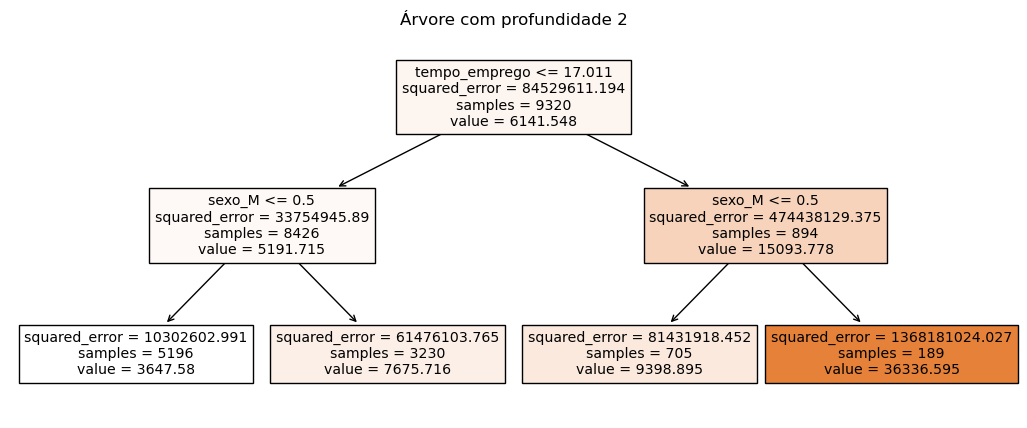

In [801]:
# Visualizando a árvore de profundidade 2
plt.figure(figsize=[13,5])
tree.plot_tree(
    reg_1,
    feature_names=x.columns,
    filled=True
)
plt.title('Árvore com profundidade 2')

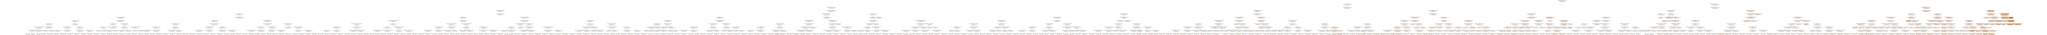

In [802]:
# Visualizando a árvore de profundidade 10
import graphviz

tree_data = tree.export_graphviz(
    reg_2,
    feature_names=x.columns,
    filled=True
)
# Gerando a visualização 
graph = graphviz.Source(tree_data, format='png')
graph

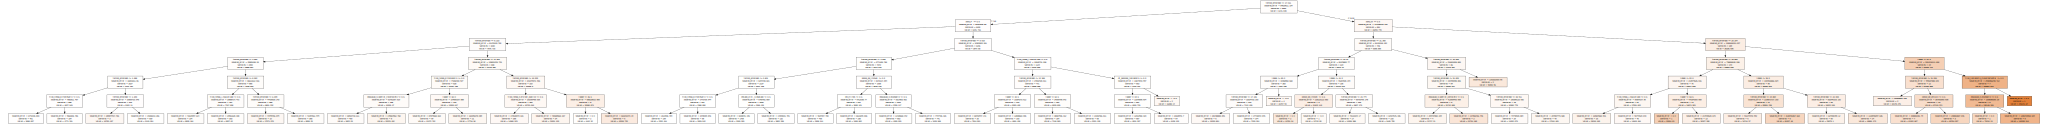

In [803]:
# Visualizando a árvore de profundidade 6
tree_ = tree.export_graphviz(
    reg_3,
    feature_names=x.columns,
    filled=True
)
graph = graphviz.Source(tree_, format='png')
graph